In [72]:
from datetime import datetime
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import scale

NMSE = 'neg_mean_squared_error'

In [61]:
#####
# PART - I : Create target value column & transform data
#####

X_train = pd.read_csv('yelp_train.csv')
X_test = pd.read_csv('yelp_test.csv')
predictors = list(X_train.columns)
predictors.remove('stars')
# target = 'positive'
y_train = np.array([int(v >= 4) for v in X_train['stars']])
y_test = np.array([int(v >= 4) for v in X_test['stars']])

# Transform column 'date' to timestamp format in integer type, so that temporal dynamic info can be better used
# divide (prescale) the timestamp to avoid numeric issue when scaling the whole dataset
dstr_to_timestamp = lambda s: int(datetime.strptime(s, "%Y-%m-%d").timestamp()) / 1000.0 
X_train['date'] = X_train['date'].apply(dstr_to_timestamp)
X_test['date'] = X_test['date'].apply(dstr_to_timestamp)

# Scale the data for better performance
X_train = DataFrame(scale(X_train.loc[:, predictors]), columns = predictors)
X_test = DataFrame(scale(X_test.loc[:, predictors]), columns = predictors)

# print(X_train.shape, X_test.shape)
# print(y_train.shape, y_test.shape)
n_col = len(predictors)

(1) F1-Score of LR: 0.697211155378

(2) Predictors Ranking (descending):
	 [('words', -1.6820931366473801), ('characters', 1.3489815414045836), ('cool', 1.0780081552222494), ('biz_stars', 1.0657740949547048), ('funny', -0.61165579051816077), ('useful', -0.5003196523046386), ('user_average_stars', 0.36759997808228795), ('user_funny', 0.19093141620334569), ('user_review_count', -0.19041040507195173), ('user_useful', -0.18329064329744393), ('biz_open', 0.073047557702182714), ('date', -0.047904052201944436), ('biz_review_count', -0.040167360206157569), ('user_cool', 0.032060174819822686)] 



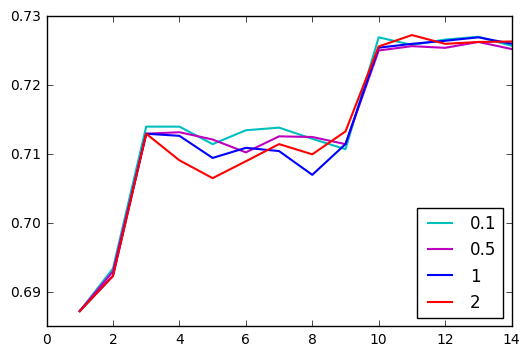


Optimal n_feature = 11, optimal MSE = 0.727295

Predictors:
 ['biz_stars', 'user_average_stars', 'words', 'characters', 'biz_review_count', 'funny', 'biz_open', 'useful', 'user_review_count', 'cool', 'user_useful']


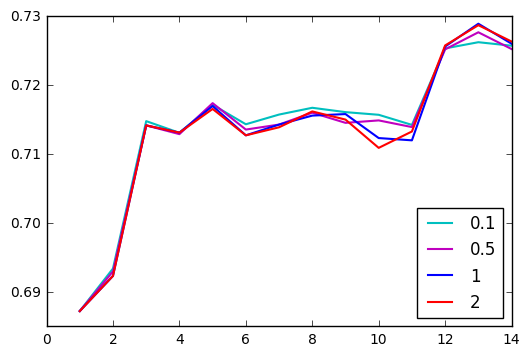


Optimal n_feature = 13, optimal MSE = 0.728945

Predictors:
 ['biz_stars', 'user_average_stars', 'characters', 'biz_review_count', 'cool', 'date', 'user_useful', 'words', 'user_funny', 'user_cool', 'user_review_count', 'useful', 'funny']


In [80]:
#####
# PART - II : Model Training & Model Selection
#####

# PART - 2.1 : Linear Regression
# ==============================

# lr = LogisticRegression()
# lr.fit(X_train, y_train)
# f1_lr = f1_score(y_test, lr.predict(X_test))
# print('(1) F1-Score of LR:', f1_lr)
# pred_rank_lr = [(pname, _) for pname, _ in sorted(zip(predictors, lr.coef_[0]), 
#                 key=lambda x: abs(x[1]), reverse=True)]
# print('\n(2) Predictors Ranking (descending):\n\t', pred_rank_lr, '\n')


#print('\n', ranked_features)

# For each possible C value in logistic regression model, 
# do feature selection separately and plot the corresponding f1-scores.
def pre_tuning_plot(f_scores):
    ranked_features = [pname for pname, _ in sorted(zip(predictors, f_scores), 
                        key=lambda x: x[1], reverse=True)]
    opt_n_feature, opt_f1 = 0, 0.0
    plt.subplot(111)
    for C, color in ((0.1, 'c'), (0.5, 'm'), (1, 'b'), (2, 'r')):
        estimator = LogisticRegression(C=C)
        scores = []
        for n_f in range(1, n_col+1):
            columns = ranked_features[:n_f]
            sc = cross_val_score(estimator, X_train.loc[:, columns], y_train, scoring='f1', cv=5).mean()
            # estimator.fit(X_train.loc[:, columns], y_train)
            # sc = f1_score(y_test, estimator.predict(X_test.loc[:, columns]))
            scores.append(sc)
            if sc > opt_f1:
                opt_n_feature, opt_f1 = n_f, sc
        plt.plot(range(1, n_col+1), scores, color, linewidth=1.5, label=str(C))
    plt.legend(loc='lower right')
    plt.show()

    print('\nOptimal n_feature = {:d}, optimal MSE = {:f}'.format(opt_n_feature, opt_f1))
    print('\nPredictors:\n', ranked_features[:opt_n_feature])

Fval, pval = f_classif(X_train, y_train)
pre_tuning_plot(Fval)
mic = mutual_info_classif(X_train, y_train)
pre_tuning_plot(mic)


In [81]:
columns = ['biz_stars', 'user_average_stars', 'characters', 'biz_review_count']
lr = LogisticRegression(C=1.0)
sc = cross_val_score(lr, X_train.loc[:, columns], y_train, scoring='f1', cv=5).mean()
print(sc)

0.713134455872


MSE of Decision Tree: 0.0259314731095


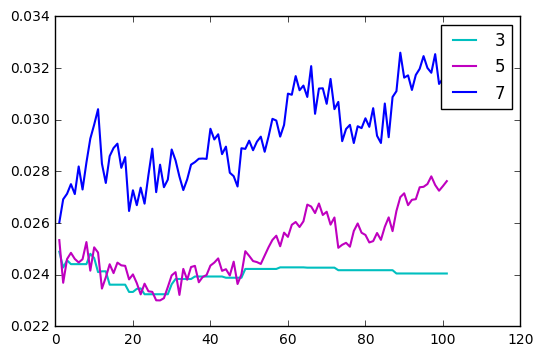


Optimal n_feature = 27, optimal MSE = 0.023008

Predictors:
 ['PctIlleg', 'PctKids2Par', 'PctFam2Par', 'racePctWhite', 'PctYoungKids2Par', 'PctTeen2Par', 'racepctblack', 'pctWPubAsst', 'pctWInvInc', 'FemalePctDiv', 'TotalPctDiv', 'PctPopUnderPov', 'PctPersOwnOccup', 'MalePctDivorce', 'PctUnemployed', 'PctVacantBoarded', 'PctHousNoPhone', 'PctNotHSGrad', 'PctHousLess3BR', 'PctHousOwnOcc', 'NumIlleg', 'PctPersDenseHous', 'NumUnderPov', 'medFamInc', 'medIncome', 'HousVacant', 'PctLess9thGrade']


DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [6]:
# PART - 2.2 : Decision Tree
# ===========================
# PART - 2.2.1: Default Model 

model_tree = DecisionTreeRegressor(max_depth=5)
model_tree.fit(X_train, y_train)
mse_tree = mean_squared_error(y_test, model_tree.predict(X_test))
print('MSE of Decision Tree:', mse_tree)

# PART - 2.2.2 : Model Selection
# First, rank each feature by their F-value to targets in descendant order.
Fval, pval = f_regression(X_train, y_train)
ranked_features = [pname for pname, _ in sorted(zip(predictors, Fval), 
                                                key=lambda x: x[1], reverse=True)]

# For each possible hyper-parameter max_depth's value in tree model, 
# do feature selection separately and plot the corresponding MSE scores.
opt_n_feature, opt_mse = 0, 1.0
plt.figure()
for max_depth, color in ((3, 'c'), (5, 'm'), (7, 'b')):
    estimator = DecisionTreeRegressor(max_depth=max_depth)
    scores = []
    for n_f in range(1, n_col+1):
        columns = ranked_features[:n_f]
        sc = - cross_val_score(estimator, X_train.loc[:, columns], y_train, scoring=NMSE, cv=5).mean()
        scores.append(sc)
        if sc < opt_mse:
            opt_n_feature, opt_mse = n_f, sc
    plt.plot(range(1, n_col+1), scores, color, linewidth=1.5, label=str(max_depth))
plt.legend(loc='upper right')
plt.show()
print('\nOptimal n_feature = {:d}, optimal MSE = {:f}'.format(opt_n_feature, opt_mse))
print('\nPredictors:\n', ranked_features[:opt_n_feature])

# PART - 2.2.3 : Summary
# The basic tree model achieves a MSE = 2.59e-2, 
# while after trying out different selection of max_depth, 
# we settle down on using max_depth=5 & 27 most relevant features as printed below,
# achieved a better MSE at 2.30e-2.
# It is easy to see that on a smaller set of features, max_depth=3 & 5 performs similar,
# while when more predictors are introduced to the model, deeper trees tend to get over-fitted.

model_tree = DecisionTreeRegressor(max_depth=5)
model_tree.fit(X_train.loc[:, ranked_features[:opt_n_feature]], y_train)

MSE of Random Forest: 0.0258761322156

Optimal n_feature = 68, optimal MSE = 0.019364


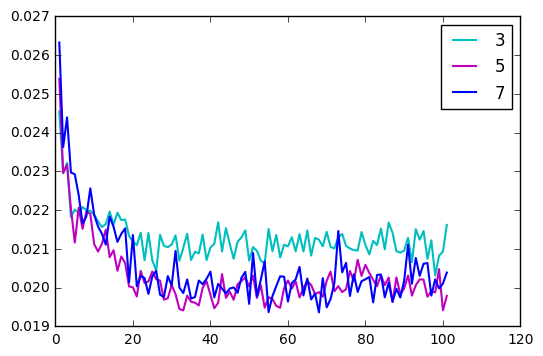

In [7]:
# PART - 2.3 : Random Forest
# ===========================
# PART - 2.3.1: Default Model

model_forest = RandomForestRegressor(n_estimators=10, max_depth=3)  # default setting
model_forest.fit(X_train, y_train)
mse_forest = mean_squared_error(y_test, model_forest.predict(X_test))
print('MSE of Random Forest:', mse_forest)

# PART - 2.3.2 : Model Selection (Basic)
# As we already have features ranked by their F-value to targets in descendant order
# (from last section), we can try a similar plot with max_depth=(3, 5, 7) to see the trend.
opt_n_feature, opt_mse = 0, 1.0
plt.figure()
for mdepth, color in [(3, 'c'), (5, 'm'), (7, 'b')]:
    estimator = RandomForestRegressor(n_estimators=10, max_depth=mdepth)
    scores = []
    for n_f in range(1, n_col+1):
        columns = ranked_features[:n_f]
        sc = - cross_val_score(estimator, X_train.loc[:, columns], y_train, scoring=NMSE, cv=3).mean()
        scores.append(sc)
        if sc < opt_mse:
            opt_n_feature, opt_mse = n_f, sc
    plt.plot(range(1, n_col+1), scores, color, linewidth=1.5, label=str(mdepth))
plt.legend(loc='upper right')
print('\nOptimal n_feature = {:d}, optimal MSE = {:f}'.format(opt_n_feature, opt_mse))
plt.show()

In [31]:
# PART - 2.3.3 : Model Selection (GridSearch)

# This step is separated in an individual cell for its time consuming nature.
# From the plot in last step we can find this time, unlike single tree regressor, 
# the shallower forests predicts worst, and max_depth=5 & 7 compete with each other.
# Another thing is, as number of features supplied increases, overfitting is not obvious,
# saying the decreasing trend of MSE is not significantly related to max_depth.

# So we still use the number of optimal features as we obtained from last preliminary part,
# and perform grid search to two most important hyper-parameters in model.
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': range(3, 11), 'max_depth': range(3, 11)}
clf = GridSearchCV(RandomForestRegressor(), parameters, scoring=NMSE, cv=5)
columns = ranked_features[:opt_n_feature]
clf.fit(X_train.loc[:, columns], y_train)
grid_scores = DataFrame(clf.cv_results_)[['rank_test_score', 'mean_test_score', 'params']]


(1) Optimal n_estimators = 10, optimal max_depth = 7, optimal MSE = 0.019790


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


(2) Forest Model Out-of-bag Score: 0.579589


(3) 10 Most Important Predictors (descending):
	 ['PctIlleg', 'PctKids2Par', 'racePctWhite', 'NumIlleg', 'PctHousLess3BR', 'HousVacant', 'numbUrban', 'state', 'pctWInvInc', 'PctPersDenseHous']


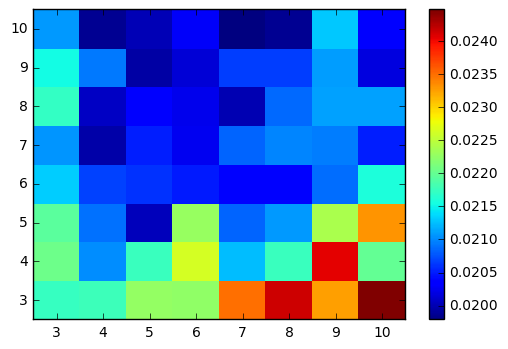

In [32]:
def heatmap(df, xticks, yticks):
    fig, ax = plt.subplots()
    grid = plt.pcolor(df)
    ax.set_yticks(np.arange(8) + 0.5)
    ax.set_xticks(np.arange(8) + 0.5)
    ax.set_yticklabels(yticks)
    ax.set_xticklabels(xticks)
    cb = fig.colorbar(grid)
    plt.show()
    
# PART - 2.3.4 : Model Selection (Visualization)

# I tried plotted a heatmap to represent the complex tradeoff between n_estimators & max_depth,
# obtained a somewhat radiant colored mesh grid.

param_range = list(range(3, 11))
hmap_df = DataFrame(index=param_range, columns=param_range, dtype=float)
best_sc = best_n_estimator = best_max_depth = 1.0
for _, row in grid_scores.iterrows():
    sc, params = - row['mean_test_score'], row['params']
    n_estimators, max_depth = params['n_estimators'], params['max_depth']
    hmap_df.loc[n_estimators, max_depth] = sc
    if sc < best_sc:
        best_sc = sc
        best_n_estimator, best_max_depth = n_estimators, max_depth

# PART - 2.3.5 : Summary
print('\n(1) Optimal n_estimators = {:d}, optimal max_depth = {:d}, optimal MSE = {:f}'
      .format(best_n_estimator, best_max_depth, best_sc))

model_forest = RandomForestRegressor(
    n_estimators=best_n_estimator, max_depth=best_max_depth, oob_score=True)
model_forest.fit(X_train.loc[:, ranked_features[:opt_n_feature]], y_train)
print('(2) Forest Model Out-of-bag Score: {:f}\n'.format(model_forest.oob_score_))

pred_rank_rf = [pname for pname, coef in sorted(
    zip(ranked_features[:opt_n_feature], model_forest.feature_importances_), 
    key=lambda x: abs(x[1]), reverse=True)][:10]
print('\n(3) 10 Most Important Predictors (descending):\n\t', pred_rank_rf)

heatmap(hmap_df, param_range, param_range)

# The basic random forest model achieves a MSE = 2.58e-2, 
# while after trying out different selection of max_depth & n_estimators & features, 
# we settle down on using n_estimator=10, max_depth=7, 
# with 68 relevant features as printed below,
# achieved a better MSE at 1.98e-2.
# Other attributes such as most important features & OOB-score are printed below.

MSE of Gradient Boosting: 0.0203570411922


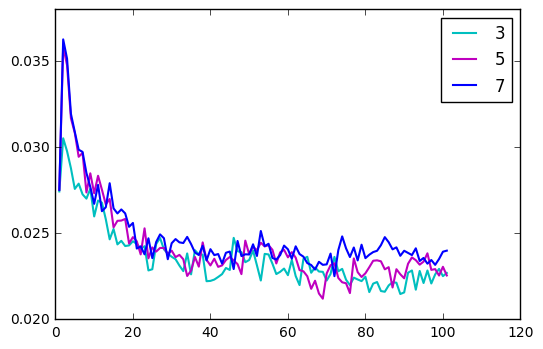


Optimal n_feature = 69, optimal MSE = 0.021204


In [257]:
# PART - 2.4 : Gradient Boosting
# ===========================
# PART - 2.4.1: Default Model

model_gb = GradientBoostingRegressor()
model_gb.fit(X_train, y_train)
mse_gb = mean_squared_error(y_test, model_gb.predict(X_test))
print('MSE of Gradient Boosting:', mse_gb)

# PART - 2.4.2: Model Selection (Basic)
# As we already have features ranked by their F-value to targets in descendant order
# (from PART 2.2), we can try a similar plot with max_depth=(3, 5, 7) to see the trend.
opt_n_feature, opt_mse = 0, 1.0
plt.figure()
for mdepth, color in ((3, 'c'), (5, 'm'), (7, 'b')):
    estimator = GradientBoostingRegressor(learning_rate=0.5, max_depth=mdepth)
    scores = []
    for n_f in range(1, n_col+1):
        columns = ranked_features[:n_f]
        sc = - cross_val_score(estimator, X_train.loc[:, columns], y_train, scoring=NMSE, cv=3).mean()
        scores.append(sc)
        if sc < opt_mse:
            opt_n_feature, opt_mse = n_f, sc
    plt.plot(range(1, n_col+1), scores, color, linewidth=1.5, label=str(mdepth))
plt.legend(loc='upper right')
plt.show()
print('\nOptimal n_feature = {:d}, optimal MSE = {:f}'.format(opt_n_feature, opt_mse))

In [13]:
# PART - 2.4.3 : Model Selection (GridSearch)

# This step is separated in an individual cell for its time consuming nature.
# From the plot in last step we can find : as number of features supplied increases, 
# overfitting is not obvious, while the trend of MSE drops is almost irrelevant to max_depth.

# So we still use the number of optimal features as we obtained from last preliminary part,
# and perform grid search to two most important hyper-parameters in model.
# Because from last plot we can see max_depth=7 usually performs worse than shallower ones,
# our search range could be compressed.
parameters = {'learning_rate': [0.1, 0.2, 0.5, 1, 2], 'max_depth': range(3, 7)}
clf = GridSearchCV(GradientBoostingRegressor(), parameters, scoring=NMSE, cv=5)
columns = ranked_features[:opt_n_feature]
clf.fit(X_train.loc[:, columns], y_train)
grid_scores = DataFrame(clf.cv_results_)[['rank_test_score', 'mean_test_score', 'params']]

Grid Search Scores:
     rank_test_score  mean_test_score                                  params
0                 2         0.018372  {'learning_rate': 0.1, 'max_depth': 3}
1                 1         0.018319  {'learning_rate': 0.1, 'max_depth': 4}
2                 3         0.018578  {'learning_rate': 0.1, 'max_depth': 5}
3                 4         0.018913  {'learning_rate': 0.1, 'max_depth': 6}
4                 7         0.019538  {'learning_rate': 0.2, 'max_depth': 3}
5                 6         0.019412  {'learning_rate': 0.2, 'max_depth': 4}
6                 5         0.019388  {'learning_rate': 0.2, 'max_depth': 5}
7                 8         0.019684  {'learning_rate': 0.2, 'max_depth': 6}
8                 9         0.022304  {'learning_rate': 0.5, 'max_depth': 3}
9                10         0.023493  {'learning_rate': 0.5, 'max_depth': 4}
10               12         0.024269  {'learning_rate': 0.5, 'max_depth': 5}
11               11         0.024233  {'learning_rate':

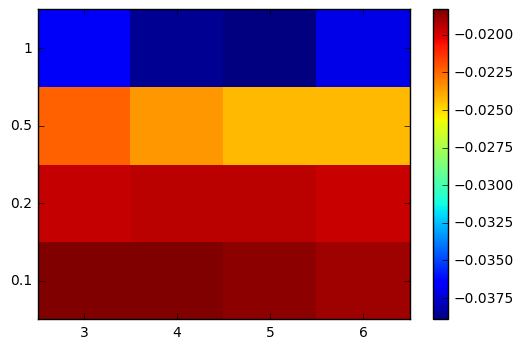



 (1) Optimal learning_rate = 0.100000, optimal max_depth = 4, optimal MSE = 0.018319

(2) 10 Most Important Predictors (descending):
	 ['PctKids2Par', 'PctIlleg', 'racepctblack', 'state', 'PctVacantBoarded', 'MedRentPctHousInc', 'HispPerCap', 'pctWWage', 'PopDens', 'PctYoungKids2Par']


In [27]:
def heatmap2(df, xticks, yticks):
    fig, ax = plt.subplots()
    grid = plt.pcolor(df)
    ax.set_yticks(np.arange(4) + 0.5)
    ax.set_xticks(np.arange(4) + 0.5)
    ax.set_yticklabels(yticks)
    ax.set_xticklabels(xticks)
    cb = fig.colorbar(grid)
    plt.show()

# PART - 2.4.4 : Model Selection (Visualization)

# I tried plotted a heatmap to represent the complex tradeoff between learning_rate & max_depth,
# obtained a somewhat radiant colored mesh grid.
# By printing out the result dataframe, as when learning_rate >= 2.0, the GB will not 
# converge, so we only visualize smaller learning_rate situations.

grid_scores['mean_test_score'] = np.fabs(grid_scores['mean_test_score'])
print('Grid Search Scores:\n', grid_scores)

hmap_df = DataFrame(index=[0.1, 0.2, 0.5, 1], columns=range(3, 7), dtype=float)
for _, row in grid_scores.iterrows():
    params = row['params']
    learning_rate, max_depth = params['learning_rate'], params['max_depth']
    if learning_rate < 2.0:
        hmap_df.loc[learning_rate, max_depth] = - row['mean_test_score']

heatmap2(hmap_df, range(3, 7), [0.1, 0.2, 0.5, 1])

# PART - 2.4.5 : Summary
best_row_selector = grid_scores['rank_test_score'] == 1
best_sc = grid_scores.loc[best_row_selector, 'mean_test_score'].values[0]
params = grid_scores.loc[best_row_selector, 'params'].values[0]
best_learning_rate, best_max_depth = params['learning_rate'], params['max_depth']
print('\n\n (1) Optimal learning_rate = {:f}, optimal max_depth = {:d}, '
      'optimal MSE = {:f}'.format(best_learning_rate, best_max_depth, best_sc))

# Re-train the model using optimal hyper-parameters
model_gb = GradientBoostingRegressor(learning_rate=best_learning_rate, max_depth=best_max_depth)
model_gb.fit(X_train.loc[:, ranked_features[:opt_n_feature]], y_train)

pred_rank_gb = [pname for pname, coef in sorted(
    zip(ranked_features[:opt_n_feature], model_gb.feature_importances_), 
    key=lambda x: abs(x[1]), reverse=True)][:10]
print('\n(2) 10 Most Important Predictors (descending):\n\t', pred_rank_gb)

# The basic gradient boosting model achieves a MSE = 2.04e-2, 
# while after trying out different selection of max_depth & learning_rate & features, 
# we settle down on using learning_rate=0.1, max_depth=4, 
# with 69 relevant features as printed below, achieved a better MSE at 1.83e-2.
# According to the heatmap, the smaller learning_rate is, the more training time consumed yet more precise.
# Other attributes such as most important features are printed below.

In [35]:
#####
# PART - III : Compare and Summarize Different Models with Optimal Hyper-parameters
#####

opt_n_features = {'tr': 27, 'rf': 68, 'gb': 69}
mse_lr = mean_squared_error(y_test, model_lr.predict(X_test))
mse_tr = mean_squared_error(y_test, model_tree.predict(X_test.loc[:, ranked_features[:opt_n_features['tr']]]))
mse_rf = mean_squared_error(y_test, model_forest.predict(X_test.loc[:, ranked_features[:opt_n_features['rf']]]))
mse_gb = mean_squared_error(y_test, model_gb.predict(X_test.loc[:, ranked_features[:opt_n_features['gb']]]))
print('\nTest MSE of Linear Regression:', mse_lr)
print('\nTest MSE of Decision Tree:', mse_tr)
print('\nTest MSE of Random Forest:', mse_rf)
print('\nTest MSE of Gradient Boosting:', mse_gb)

# Ensemble models are usually more robust to various noisy features, 
# and faulty hyper-parameter settings; meanwhile, single decision tree models tend to overfit if tree is too deep.
# To achieve better performace in MSE and generality, 
# (1) for Random Forest, tune 'max_depth' and set a larger 'n_estimators' if time is not a problem;
# (2) for Gradient Boosting, tune 'max_depth' and set a smaller 'learning_rate' if time is not a problem, 
# while 'n_estimators' is set to 100 by default and is usually sufficient (tradeoff to 'learning_rate').

# The optimal gradient boosting method out performs linear regression model with all predictors.


Test MSE of Linear Regression: 0.0209962471269

Test MSE of Decision Tree: 0.0256968342376

Test MSE of Random Forest: 0.0237258269376

Test MSE of Gradient Boosting: 0.0194920390024
